## The Start

In [1]:
import optuna
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
from sklearn.preprocessing import MinMaxScaler    

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

In [2]:
SEED = 777
torch.manual_seed(SEED)
np.random.seed(SEED)

#-------------------------
BATSIZE = 32
xseq_len = 5
yseq_len = 4

## GPU

In [3]:
print("============================================================================================")
# set device to cpu or cuda
device = torch.device('cpu')
if(torch.cuda.is_available()): 
    device = torch.device('cuda:0') 
    torch.cuda.empty_cache()
    print("Device set to : " + str(torch.cuda.get_device_name(device)))
else:
    print("Device set to : cpu")
print("============================================================================================")

Device set to : NVIDIA GeForce RTX 2080 Ti


## Data

In [4]:
df = pd.read_excel('pv_data.xlsx')
df.drop(columns=['solar irradience(invalid)'], inplace=True)

In [5]:
display(df.shape)
display(df.head(3))

(65535, 8)

,time,wind speed,wind direction,ambient temperature,pressure,humidity,solar irradience,PV power output
0,2017-01-01 00:15:00,-0.320896,-0.066011,-0.024088,-0.614618,-0.059871,0.0,0.0
1,2017-01-01 00:30:00,-0.335821,-0.067956,-0.025996,-0.606476,-0.058252,0.0,0.0
2,2017-01-01 00:45:00,-0.350746,-0.069789,-0.027427,-0.598417,-0.055825,0.0,0.0


## Scaling

In [6]:
scaler = MinMaxScaler()

X = df.iloc[:, 1:-1].values
Y = df.iloc[:, -1].values.reshape(-1, 1)
infeature_len = X.shape[-1]

X_scaled = scaler.fit_transform(X)
Y_scaled = scaler.fit_transform(Y)

display(f'X: {X.shape}')
display(f'Y: {Y.shape}')

display(df.head(3))

'X: (65535, 6)'

'Y: (65535, 1)'

,time,wind speed,wind direction,ambient temperature,pressure,humidity,solar irradience,PV power output
0,2017-01-01 00:15:00,-0.320896,-0.066011,-0.024088,-0.614618,-0.059871,0.0,0.0
1,2017-01-01 00:30:00,-0.335821,-0.067956,-0.025996,-0.606476,-0.058252,0.0,0.0
2,2017-01-01 00:45:00,-0.350746,-0.069789,-0.027427,-0.598417,-0.055825,0.0,0.0


## Arrange

In [7]:
def seq_data(x, y, xseq_len, yseq_len):  # N=100, in=5, out=3

    xseqlist = []
    yseqlist = []
    it = (len(x) - xseq_len) // yseq_len # 몫

    for i in range(it):
        xseqlist.append(x[i*yseq_len: i*yseq_len + xseq_len])
        yseqlist.append(y[xseq_len + i*yseq_len: xseq_len + i*yseq_len + yseq_len])
        # e.g.
        # x[0*3: 0*3 + 5]        =x[0:5],     x[1*3: 1*3 + 5]        =x[3:8] 
        # y[5 + 0*3: 5 + 0*3 + 3]=y[5:8],     y[5 + 1*3: 5 + 1*3 + 3]=y[8:11]
        #
        # x[92:97]
        # y[97:100]

    return torch.tensor(xseqlist, dtype=torch.float32).to(device), torch.tensor(yseqlist, dtype=torch.float32).to(device)

In [8]:
X_seq, Y_seq = seq_data(x=X_scaled, y=Y_scaled, xseq_len=xseq_len, yseq_len=yseq_len)

split_trvaltest = int(len(X_seq)*0.9)

x_trainval = X_seq[:split_trvaltest]
y_trainval = Y_seq[:split_trvaltest]
x_test = X_seq[split_trvaltest:] 
y_test = Y_seq[split_trvaltest:]

split_trval = int(len(x_trainval)*0.8)

x_train = x_trainval[:split_trval] 
y_train = y_trainval[:split_trval]
x_val = x_trainval[split_trval:] 
y_val = y_trainval[split_trval:]

print(X_seq.shape, Y_seq.shape)
print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)
print(x_test.shape, y_test.shape)

# e.g. torch.Size([6553, 5, 6]) torch.Size([6553, 2, 1])
# input:  하루 당 feature가 6개이고, 5일치를 묶어서 입력함. 
# output: 하루마다 어떤 point 값(사이즈 1)을 출력하는데, 2일치를 묶어서 할 거임.

torch.Size([16382, 5, 6]) torch.Size([16382, 4, 1])
torch.Size([11794, 5, 6]) torch.Size([11794, 4, 1])
torch.Size([2949, 5, 6]) torch.Size([2949, 4, 1])
torch.Size([1639, 5, 6]) torch.Size([1639, 4, 1])


C:\Users\user\AppData\Local\Temp/ipykernel_98052/2859086841.py:17: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ..\torch\csrc\utils\tensor_new.cpp:201.)
  return torch.tensor(xseqlist, dtype=torch.float32).to(device), torch.tensor(yseqlist, dtype=torch.float32).to(device)


## Loader

In [9]:
# sequential data라 모든 epoch에서 같은 패턴만 보게 됨.,
# 모델이 시계열의 순서 그 자체를 학습하게 될 우려가 있음. ----> shuffle=True
trainset = TensorDataset(x_train, y_train)
trainloader = DataLoader(trainset, batch_size=BATSIZE, shuffle=True, drop_last=True)

# Validation과 Test는 말 그대로 평가의 의미가 있으므로 
# 같은 패턴을 유지해야 비교할 수 있음. ----> shuffle=False
valset = TensorDataset(x_val, y_val)
valloader = DataLoader(valset, batch_size=BATSIZE, shuffle=False, drop_last=True)

testset = TensorDataset(x_test, y_test)
testloader = DataLoader(testset, batch_size=BATSIZE, shuffle=False, drop_last=True)

In [10]:
for x, y in trainloader:
    display(x.shape)
    display(y.shape)
    break

torch.Size([32, 5, 6])

torch.Size([32, 4, 1])

## __🟨Encoder🟨__
- 입력 seq를 고정된 크기의 벡터로 변환.
- 입력 시퀀스의 각 시간 스텝마다 RNN은 해당 시간 스텝의 입력과 이전 시간 스텝에서의 hidden 상태를 사용하여 hidden 상태와 cell 상태를 갱신합니다.

- out은 LSTM 레이어의 모든 시간 스텝에서의 출력을 담고 있는 텐서입니다. LSTM은 시퀀스를 읽으면서 각 시간 스텝마다 해당 스텝의 출력을 계산합니다. 따라서 out은 (batch_size, time_steps, hidden_size) 크기의 텐서이며, time_steps 개수의 시간 스텝에 해당하는 출력들을 모두 포함합니다. 각 시간 스텝에서의 hidden을 모두 모은 것!

In [11]:
# out, (hn, cn) = self.lstm
# out: containing the output features (h_t) from the last layer of the LSTM, for each t.
# hn:  containing the final hidden state for each element in the sequence.
# cn:  containing the final cell state for each element in the sequence.
# 출처 - 파이토치 공식 문서

class Encoder(nn.Module):
    def __init__(self, input_len, hidden_len, num_layers):
        super(Encoder, self).__init__()
        self.input_len = input_len
        self.hidden_len = hidden_len
        self.num_layers = num_layers
        self.lstm = nn.LSTM(self.input_len, self.hidden_len, self.num_layers, batch_first=True)

    # (배치사이즈, 5스텝, 6개 피쳐)
    # x: (32, 5, 6)
    def forward(self, x):
        # h0: (2, 32, 8) 8개짜리 단일로 32개, two layer
        h0 = torch.zeros((self.num_layers, x.shape[0], self.hidden_len)).to(device)
        c0 = torch.zeros((self.num_layers, x.shape[0], self.hidden_len)).to(device)

        # self.hc는 hidden과 cell state의 tuple임.
        # out은 6초에 대한 값.
        self.lstm.flatten_parameters()
        out, self.hc = self.lstm(x, (h0, c0))        

        # out: (32, 5, 8)       ----> 매 timestep에(총 5개) 8크기 hidden을 뽑아내줌.
        # self.hc[0]: (2, 32, 8)----> 마지막 timestep의 hidden. 각 5일치에서 마지막 것만 뽑아내니까 32개.
        #                             two layer니까 2가 됨.
        return out, self.hc

## __🟨Decoder🟨__
- Encoder로부터 받은 인코딩 벡터(hidden)와 이전 시점의 출력(예측)을 입력으로 받아 출력 시퀀스를 생성하는 역할을 합니다.
- LSTM 또는 GRU와 같은 RNN 계열의 네트워크를 통해 이 입력들을 처리하여 현재 시점의 출력을 예측합니다.
- 이 예측된 출력은 다음 시점의 입력으로 사용됩니다. 즉, Decoder는 이전 시점의 출력을 현재 시점의 입력으로 사용하여 시퀀스를 점진적으로 생성합니다.
- 이렇게 예측된 6초의 출력을 다음 시간 스텝의 입력으로 사용하여 7초에 해당하는 출력을 예측합니다.

In [12]:
class Decoder(nn.Module):
    def __init__(self, input_len, hidden_len, num_layers, output_len):
        super(Decoder, self).__init__()
        self.input_len = input_len
        self.hidden_len = hidden_len
        self.num_layers = num_layers
        self.output_len = output_len
        self.lstm = nn.LSTM(self.input_len, self.hidden_len, self.num_layers, batch_first=True)
        self.linear = nn.Linear(self.hidden_len, self.output_len) # self.input_size 사용.

    # encoder_hc: (2, 32, 8) ----> (h0, c0)의 역할
    #                              8개짜리 단일로 32개, two layer
    def forward(self, x, encoder_hc):
        # x: (32, 1, 6)
        self.lstm.flatten_parameters()
        out, self.hc = self.lstm(x, encoder_hc)
        # out:    (32, 1, 8)
        # self.h: (2, 32, 8)
        # self.c: (2, 32, 8)
        out = self.linear(out)
        # out:    (32, 1, 6) ----> Decoder에 다시 넣기 위해 input과 같은 shape을 가져야 함.
        return out

## __🟨Karina🟨__
- 최종 예측 출력단에서 output_seq 길이에 맞게 reduction 해줌.

In [13]:
class Karina(nn.Module):
    def __init__(self, input_len, hidden_len, output_len):
        super(Karina, self).__init__()
        self.input_len = input_len
        self.hidden_len = hidden_len
        self.output_len = output_len
        self.linear1 = nn.Linear(self.input_len, self.hidden_len)
        self.linear2 = nn.Linear(self.hidden_len, self.output_len)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.linear1(x)
        x = self.relu(x)
        x = self.linear2(x)
        x = self.relu(x)
        return x

## __🟨Attention🟨__

In [14]:
class Attention(nn.Module):
    def __init__(self,):
        super(Attention, self).__init__()
        

## __🟨Seq2Seq🟨__
- encoder에서는 입력 시퀀스를 받아 context vector(hidden, cell)를 decoder에 전달.
- decoder는 context vector를 입력 받아 다음 시점 값을 예측함. 그 예측이 다시 다음 timestep에 입력으로 들어가 또 예측. 이걸 반복.

#### Teacher Forcing
- decoder의 (t-1)예측이 t에 input으로 들어가는 것은 테스트할 때의 사용법임!
- teacher forcing은 (t-1)을 t에 input으로 사용하지 않고 t 시점 실제 값을 입력으로 넣어 학습시킴!

#### cons
- context vector 만들면서 정보 손실.
- 입력 길어지면 성능 저하.

In [15]:
class Seq2Seq(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, xseq_len, yseq_len, batch_len):
        super(Seq2Seq, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_size = output_size
        self.xseq_len = xseq_len
        self.yseq_len = yseq_len
        self.batch_len = batch_len

        self.karina = Karina(input_len=self.input_size*self.yseq_len, hidden_len=128, output_len=self.yseq_len)
        self.encoder = Encoder(self.input_size, self.hidden_size, self.num_layers)
        self.decoder = Decoder(self.input_size, self.hidden_size, self.num_layers, self.input_size)

    # y_data와 teacher_prob는 teacher forcing할 때 넣는 거임.
    def forward(self, x_data): 
        # x_data: (32, 5, 6)
        # y_data: (32, 4, 1)
        encoder_out, encoder_hc = self.encoder(x_data)
        # encoder_out:  (32, 5, 8)
        # encoder_hc[0]:(2, 32, 8)  
        # encoder_hc[1]:(2, 32, 8)  

        decoder_in = x_data[:, -1, :].unsqueeze(1)
        # decoder_init_input: (32, 6).unsqueeze(1) = (32, 1, 6)
        # feature 6개짜리로 5일 중 마지막 날만 뽑음. 그게 32개 Batch.
        # Decoder 클래스에서 hidden+cell 전달하면서 같이 전달함.

        dcdoutbox = torch.zeros((self.batch_len, 1), dtype=torch.float32).to(device)

        for t in range(self.yseq_len):
            decoder_out = self.decoder(decoder_in, encoder_hc)
            # decoder_out: (32, 1, 6)

            dcdoutbox = torch.cat([dcdoutbox, decoder_out.squeeze(1)], axis=1)
            # decoder_out.squeeze(1): (32, 6)

            decoder_in = decoder_out

        dcdoutbox = dcdoutbox[:, 1:]
        # dcdoutbox: (32, 6*4)

        y_pred = self.karina(dcdoutbox)
        # y_pred: (32, 4)
        y_pred = y_pred.unsqueeze(2)
        # y_pred: (32, 4, 1)


        #--------------------------------------------------------------------------------------
        # Teacher Forcing 과정인데 ----> 아래 문제 때문에 사용 불가. 그래서 안 씀.
        # decoder_in: (32, 1, 6)
        # y_true: (32, 1, 1)    
        '''
        # 출력시퀀스 길이: 4 {0, 1, 2, 3}
        # 
        for t in range(4):
            decoder_out = self.decoder(decoder_in, encoder_hc)
            # t=0일 때,
            # decoder_out: (32, 1, 6)
            # feature 6개짜리로 한 개 스텝에 대해 출력. 그게 32개 Batch.

            # teacher forcing 수행(for Training).
            if torch.rand(1).item() <= teacher_prob:
                decoder_in = y_data[:, t, :]
            
            # teacher forcing Off(prob=0.0, for Test).
            else:
                decoder_in = decoder_out
        '''
        
        return y_pred

## __🟨Training🟨__

In [16]:
model = Seq2Seq(input_size=infeature_len, hidden_size=8, num_layers=2, output_size=infeature_len,
                xseq_len=xseq_len, yseq_len=yseq_len, batch_len=BATSIZE).to(device)
criterion = nn.MSELoss().to(device)
optimizer = optim.RAdam(model.parameters(), lr=1e-3)

In [189]:
loss_graph = []
n = len(trainloader)

for epoch in tqdm(range(1, 800+1)):
    running_loss = 0.0
    
    for x_true, y_true in trainloader:
        
        y_pred = model(x_true)
        loss = criterion(y_pred, y_true)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    loss_graph.append(running_loss/n)
    if epoch % 100 == 0:
        print('[epoch: %d] loss: %.4f' %(epoch, running_loss/n))

 12%|█▎        | 100/800 [06:18<44:02,  3.78s/it]

[epoch: 100] loss: 0.0167


 25%|██▌       | 200/800 [12:40<38:50,  3.88s/it]

[epoch: 200] loss: 0.0133


 33%|███▎      | 266/800 [16:51<34:38,  3.89s/it]

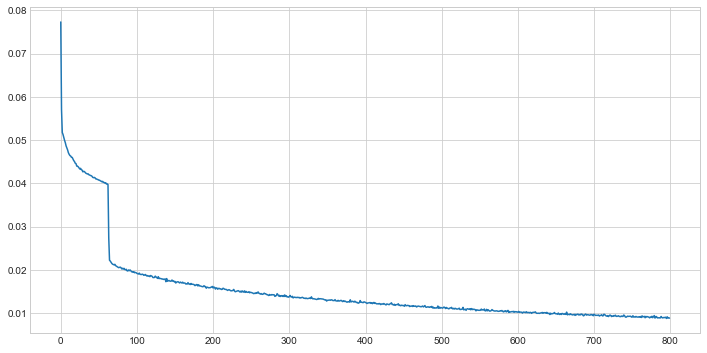

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(loss_graph)
plt.show() 

## __🟨Test🟨__

In [ ]:
test_loss_list = []
epoch_loss = 0

predlist = []

model.eval()
with torch.no_grad():
    for x, y_true in testloader:
        y_pred = model(x)
        
        kane = y_pred.flatten().cpu().tolist()
        predlist += kane

        loss = criterion(y_pred, y_true)

        epoch_loss += loss.item()
    
    test_loss_list.append(epoch_loss/n)

display(test_loss_list[0])

truelist = y_test.flatten().tolist()

print('pred_len: ', len(predlist))
print('true_len: ', len(truelist))

0.004941786548917425

pred_len:  6528
true_len:  6556


In [ ]:
print(X_seq.shape, Y_seq.shape)
print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)
print(x_test.shape, y_test.shape)
print(1639*4)

torch.Size([16382, 5, 6]) torch.Size([16382, 4, 1])
torch.Size([11794, 5, 6]) torch.Size([11794, 4, 1])
torch.Size([2949, 5, 6]) torch.Size([2949, 4, 1])
torch.Size([1639, 5, 6]) torch.Size([1639, 4, 1])
6556


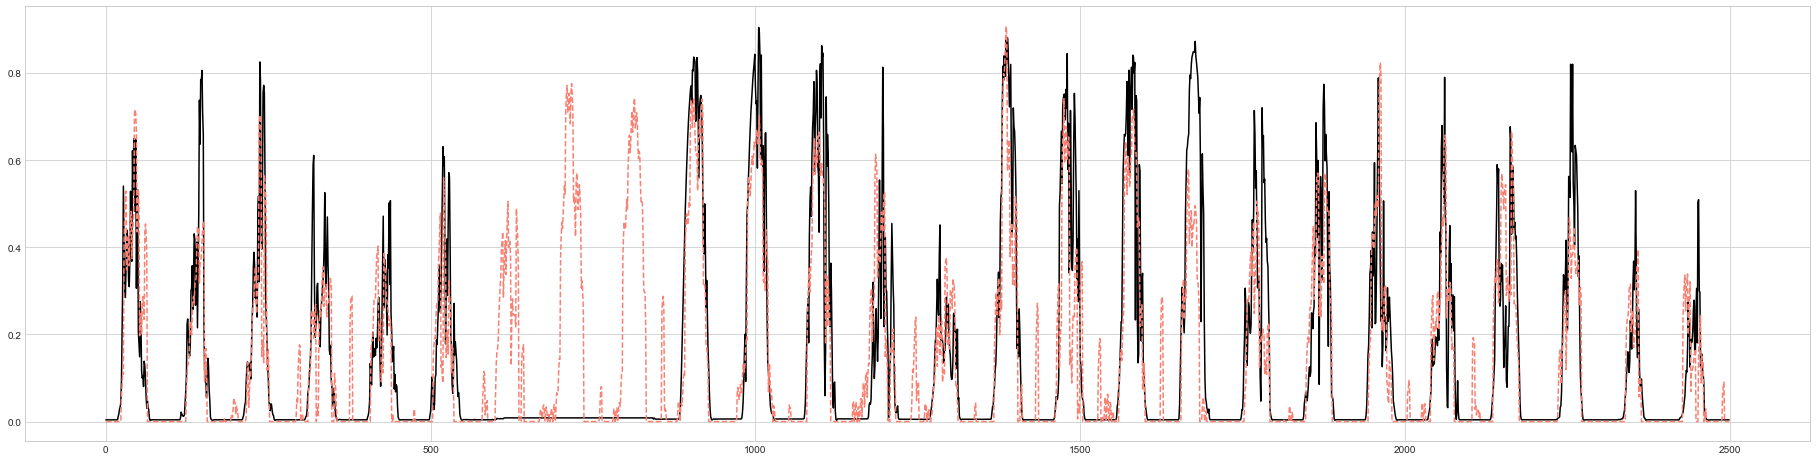

In [ ]:
cut = 2500

fig, ax = plt.subplots(1,1, figsize=(32, 8))

ax.plot(truelist[:cut], color='black')
ax.plot(predlist[:cut], color='salmon', linestyle='dashed')

plt.show()

## The End